In [93]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [94]:
import numpy as np
import pandas as pd
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [95]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [96]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")# Assign the tables to variables
Measurement = Base.classes.measurement
Station = Base.classes.station

In [97]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)

# reflect the reflected tables
Base.classes.keys()


['measurement', 'station']

In [98]:
# View all of the classes that automap found
for cls in Base.classes:
    print(cls)

<class 'sqlalchemy.ext.automap.measurement'>
<class 'sqlalchemy.ext.automap.station'>


In [115]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

print(Measurement,Station)

<class 'sqlalchemy.ext.automap.measurement'> <class 'sqlalchemy.ext.automap.station'>


In [100]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [101]:
# Find the most recent date in the data set.
Measurement = Base.classes.measurement

# Find the most recent date
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print(most_recent_date)

2017-08-23


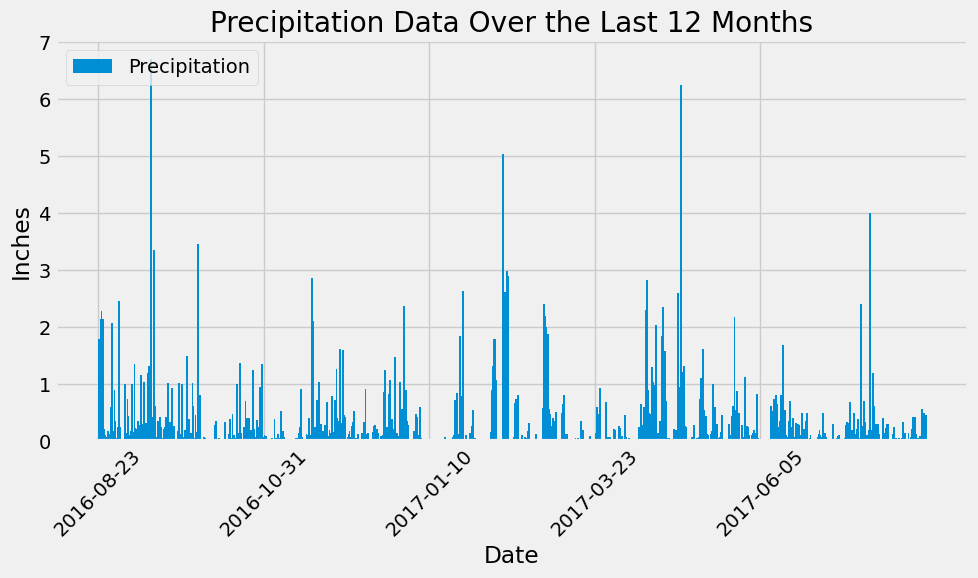

In [102]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Retrieve the most recent date from the database
most_recent_date_str = session.query(func.max(measurement.date)).scalar()

# Convert the most recent date string to a datetime object
most_recent_date = datetime.strptime(most_recent_date_str, '%Y-%m-%d')

# Calculate the date one year from the last date in the dataset
one_year_ago = most_recent_date - pd.DateOffset(years=1)

# Convert the one_year_ago datetime object to a string in the format SQLite expects
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(measurement.date, measurement.prcp).\
                        filter(measurement.date >= one_year_ago_str).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df = df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))

# Convert dates to numerical range for x-axis
x_values = range(len(df['Date']))

plt.bar(x_values, df['Precipitation'], width=5.0, label='Precipitation') 
plt.title('Precipitation Data Over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Inches')

# Adjusting x-axis ticks
plt.xticks(np.arange(0, len(df['Date']), step=len(df['Date'])//5), df['Date'][::len(df['Date'])//5], rotation=45)

plt.legend()
plt.tight_layout()
plt.show()


In [103]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary = df.describe()
summary

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [106]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(measurement.station.distinct())).scalar()

# Print the total number of stations
print("Total number of stations:", total_stations)


Total number of stations: 9


In [108]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_active = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()

station_active


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [109]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = station_active[0][0]

# Calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
                    filter(Measurement.station == most_active_station_id).all()

# Print the results
temperature_stats

[(54.0, 85.0, 71.66378066378067)]

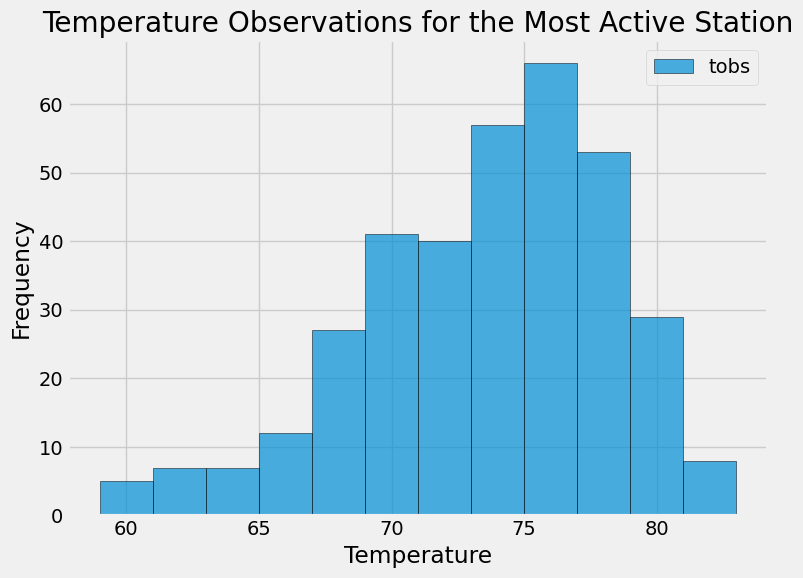

In [113]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Calculate the date 12 months prior to the most recent date
one_year_ago_temp = temp_recent_date - pd.DateOffset(years=1)

# Query the temperature observations for the most active station within the last 12 months
temperature_data = session.query(Measurement.tobs).\
                    filter(Measurement.station == most_active_station_id).\
                    filter(Measurement.date >= one_year_ago_temp.strftime('%Y-%m-%d')).all()

# Extract temperature observations from the result
temperatures = [temp[0] for temp in temperature_data]

# Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.hist(temperatures, bins=12, edgecolor='black', alpha=0.7)
plt.title('Temperature Observations for the Most Active Station')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(['tobs'], loc='best')
plt.tight_layout()
plt.show()


# Close Session

In [114]:
# Close Session
session.close()